#### Header

No need to change I guess....

In [138]:
import glob
import re
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio
import dask


target_var = "2m_temperature"

In [139]:

PRESSURE_VARIABLES=[
    "u_component_of_wind",
    "v_component_of_wind",
    "specific_humidity",
    "temperature",
    "vertical_velocity"
]

SURFACE_VARIABLES=[
    "10m_u_component_of_wind", 
    "10m_v_component_of_wind", 
    "total_precipitation_6hr", 
    "mean_sea_level_pressure",
]

def weighted_mean(dataset: xr.Dataset):
    weights = np.cos(np.deg2rad(dataset.lat))
    weights.name = "weights"
    weighted = dataset.weighted(weights)
    
    return weighted.mean(('lat', 'lon'))


def preprocess_GC(dataset:xr.Dataset, target_var="2m_temperature", region=None):
    if target_var == "2m_temperature":
        dataset = dataset.resample(time="1D").mean().squeeze('batch')
        dataset["time"] = pd.date_range("2021-06-22", periods=7, freq="1D")
        dataset = dataset.rename({"time":"date"})
        dataset = dataset.drop_vars(PRESSURE_VARIABLES + SURFACE_VARIABLES + ['level', 'geopotential'])

    elif target_var == "geopotential":
        dataset = dataset.sel(level=500).resample(time="1D").mean().squeeze('batch')
        dataset["time"] = pd.date_range("2021-06-22", periods=7, freq="1D")
        dataset = dataset.rename({"time":"date"})
        dataset = dataset.drop_vars(PRESSURE_VARIABLES + SURFACE_VARIABLES + ['level', '2m_temperature'])

    # TODO: add region selection 
    if region:
        dataset = dataset.sel(lat=slice(25, 60), lon=slice(102.5, 150))

    return dataset


def preprocess_nwp(dataset:xr.Dataset, target_var="2m_temperature", region=None):
    dataset = dataset.expand_dims(dim={'date': [dataset.time.values[0]]}).compute()
    dataset = dataset.rename({'time': 'ensemble'})
    dataset['ensemble'] = np.arange(1, 51)

    if target_var == "2m_temperature":
        dataset = dataset.drop_vars('height')

    elif target_var == "geopotential":
        dataset.gh.attrs['units'] = 'm^2/s^2'
        dataset.gh.attrs['long_name'] = 'Geopotential'
        dataset = dataset.assign_coords(lev=dataset.lev / 100)
        dataset.lev.attrs['units'] = 'hPa'
        dataset['gh'] = dataset['gh'] * 9.80665
        dataset = dataset.rename({'gh':'geopotential', 'lev':'level'})
        dataset = dataset.sel(level=500)

    # TODO: add region selection 
    if region:
        dataset = dataset.sel(lat=slice(60, 24), lon=slice(102, 150))

    return dataset

def preprocess_era(dataset:xr.Dataset, target_var="2m_temperature", region=None):
    if region:
        dataset = dataset.sel(lat=slice(60, 25), lon=slice(102.5, 150))

# Partition

1. **t2m**
    1. all + all + global  $= 4 \times 23 \times 1 = 92$  
    2. all + only t2m + all $= 4 \times 1 \times 12 = 48$  
    3. all + except t2m + all $= 4 \times 1 \times 12 = 48$  
2. **500hPa geopotential height**
    1. all + all + global  $= 4 \times 23 \times 1 = 92$  
    2. all + only geopotential + all $= 4 \times 1 \times 12 = 48$  
    3. all + except geopotential + all $= 4 \times 1 \times 12 = 48$

In [140]:
if target_var == '2m_temperature':
    p_1 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_???????????_global_scale*.nc'))
    p_2 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_00100000000_*_scale*.nc'))
    p_3 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_11011111111_*_scale*.nc'))
    
elif target_var == 'geopotential':
    p_1 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_???????????_global_scale*.nc'))
    p_2 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_00000100000_*_scale*.nc'))
    p_3 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_11111011111_*_scale*.nc'))  
    

p_4 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_11111111111_global_scale_*.nc'))


# GC Data load

In [ ]:
# Assign base colors for each partition
partition_colors = {
    'p_1': 'blue',
    'p_2': 'green',
    'p_3': 'red',
    'p_4': 'purple'
}

# Function to extract perturbation type and value from filename
def extract_perturbation_info(filename):
    match = re.search(r'_([01][01][01][01][01][01][01][01][01][01][01])_(.*?)_(scale|wipeout)_([\d.eE+-]+)\.nc$', filename)
    if match:
        var=match.group(1)
        region=match.group(2)
        perturb_type = match.group(3)
        value = match.group(4)
        return f"{value}_{region}_{var}"
    else:
        return None

# Collect perturbation files with labels and colors
perturb_files = []
for partition_name, partition_files in zip(['p_1', 'p_2', 'p_3'], [p_1, p_2, p_3]):
# for partition_name, partition_files in zip(['p_4'], [p_4]):
    base_color = partition_colors[partition_name]
    num_files = len(partition_files)
    # Generate different shades of the base color
    colors = sns.light_palette(base_color, n_colors=num_files + 2)[1:-1]
    for i, file in enumerate(partition_files):
        perturb_info = extract_perturbation_info(file)
        if perturb_info:
            label = f"{perturb_info}"
            color = colors[i % len(colors)]
            perturb_files.append((label, color, file))

perturb_datasets = []

from multiprocessing import Pool

def process_file(file_info):
    label, color, file = file_info
    dataset = weighted_mean(preprocess_GC(xr.open_dataset(file), target_var))
    return (label, color, dataset)

with Pool(processes=30) as pool:
    perturb_datasets = pool.map(process_file, perturb_files)

# NWP Data load

In [ ]:
def piping(dataset:xr.Dataset, target_var):
    return weighted_mean(preprocess_nwp(dataset, target_var))

from functools import partial
pipe = partial(piping, target_var = target_var)

if target_var == '2m_temperature':
    files = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/Dailyaveraged/t2m/nc/*/Temperature2m_2021-06-21.nc'))

elif target_var == 'geopotential':
    files = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/InstantaneousAccumulated/z/nc/*/Z_2021-06-21.nc'))

files = [f for f in files if int(f.split('/')[-2]) <= 24 * 7]
nwp = xr.open_mfdataset(
    files,
    combine='by_coords',
    preprocess=pipe
)
if target_var == "2m_temperature":
    nwp = nwp.rename({"2t":"2m_temperature"})

nwp = nwp.compute()
df = nwp[target_var].to_dataframe().reset_index()

In [ ]:

# # Plot ensemble members
# first_ensemble = True
# for ensemble in df['ensemble'].unique():
#     subset = df[df['ensemble'] == ensemble]
#     if first_ensemble:
#         plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5, label='Ensemble Members')
#         first_ensemble = False
#     else:
#         plt.plot(subset['date'], subset['2m_temperature'], color='grey', linewidth=0.5, alpha=0.5)

# # Plot ensemble mean
# mean_temp = df.groupby('date')['2m_temperature'].mean().reset_index()
# plt.plot(mean_temp['date'], mean_temp['2m_temperature'], color='black', linewidth=1, label='Ensemble Mean')

# # Plot perturbation datasets
# for label, color, dataset in perturb_datasets:
#     plt.plot(dataset['date'], dataset['2m_temperature'], color=color, linewidth=1, label=label)

# # Optional: Plot ERA5 data if available
# # era5 = xr.open_dataset("/camdata2/ERA5/daily/t2m/2021.nc").rename({"time":"date", "latitude":"lat", "longitude":"lon"}).sel(date=slice("2021-06-22", "2021-07-01"))
# # era5 = weighted_mean(era5)
# # plt.plot(era5['date'], era5['t2m'], color='red', linewidth=1.5, linestyle='dashed', label='ERA5')

# plt.title('Mean 2m Temperature Forecast / 2021-06-21  + 10 days', fontsize=16)
# plt.xlabel('Date', fontsize=12)
# plt.ylabel('Temperature (K)', fontsize=12)
# plt.legend(fontsize=5)

# # Adjust y-axis limits based on all datasets
# all_temps = []
# for _, _, dataset in perturb_datasets:
#     all_temps.extend(dataset['2m_temperature'].values)
# all_temps.extend(df['2m_temperature'].values)
# y_min = min(all_temps) - 2
# y_max = max(all_temps) + 2
# plt.ylim(y_min, y_max)

# plt.tight_layout()
# plt.show()
# # plt.savefig('figure/2m_temperature_forecast_mean_2021-06-21.png')

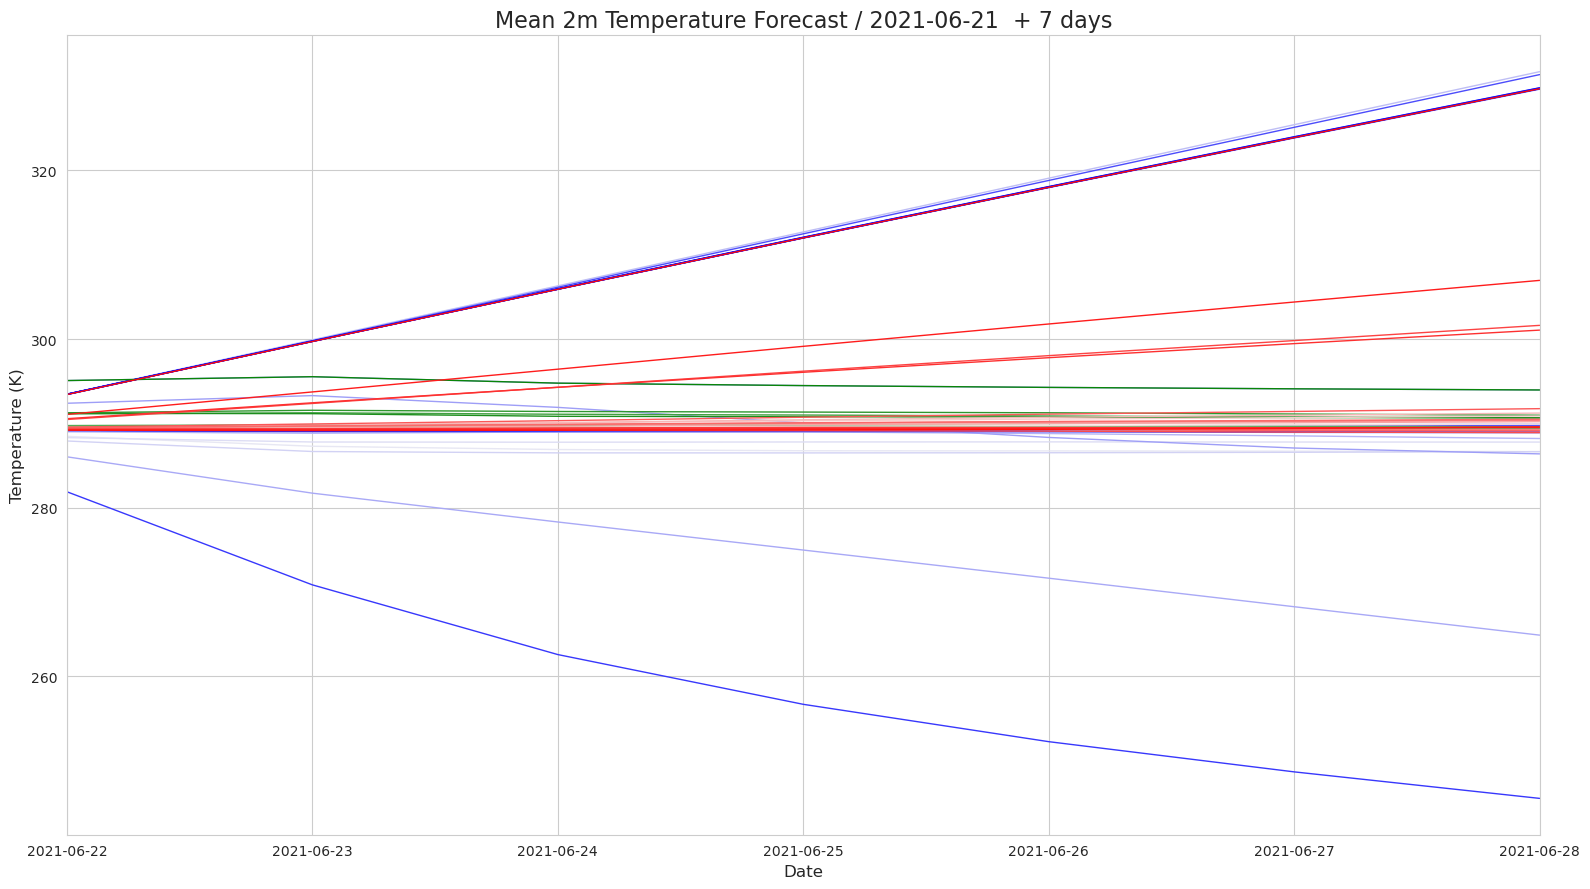

In [ ]:
plt.figure(figsize=(16, 9))
sns.set_style("whitegrid")

# Plot ensemble members
if target_var == '2m_temperature': 
    first_ensemble = True
    for ensemble in df['ensemble'].unique():
        subset = df[df['ensemble'] == ensemble]
        if first_ensemble:
            plt.plot(subset['date'], subset[target_var], color='grey', linewidth=0.5, alpha=0.5, label='Ensemble Members')         
            plt.plot(subset['date'], subset[target_var], color='black', linewidth=0.5, alpha=0.5, label='Ensemble Mean')   
            first_ensemble = False
        else:
            plt.plot(subset['date'], subset[target_var], color='grey', linewidth=0.5, alpha=0.5)


# Plot perturbation datasets
for label, color, dataset in perturb_datasets:
    plt.plot(dataset['date'], dataset[target_var], color=color, linewidth=1, label=label)

# Optional: Plot ERA5 data if available
# era5 = xr.open_dataset("/camdata2/ERA5/daily/t2m/2021.nc").rename({"time":"date", "latitude":"lat", "longitude":"lon"}).sel(date=slice("2021-06-22", "2021-07-01"))
# era5 = weighted_mean(era5)
# plt.plot(era5['date'], era5[target_var], color='red', linewidth=1.5, linestyle='dashed', label='ERA5')



plt.xlabel('Date', fontsize=12)
if target_var == '2m_temperature':
    plt.title('Mean 2m Temperature Forecast / 2021-06-21  + 7 days', fontsize=16)
    plt.ylabel('Temperature (K)', fontsize=12)
elif target_var == 'geopotential':
    plt.title('Mean 500hPa geopotential Forecast / 2021-06-21  + 7 days', fontsize=16)
    plt.ylabel('Geopotential (m^2/s^2)', fontsize=12)


# Adjust y-axis limits based on all datasets
all_temps = []
for _, _, dataset in perturb_datasets:
    all_temps.extend(dataset[target_var].values)
# all_temps.extend(df[target_var].values)
# y_min = min(mean_temp[target_var]) - 1
# y_max = max(mean_temp[target_var]) + 1
# plt.ylim(y_min, y_max)
plt.xlim([pd.Timestamp('2021-06-22'), pd.Timestamp('2021-06-28')])

plt.tight_layout()
plt.show()

#

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio
import pandas as pd


ensemble_lines = []
ensemble_legend_shown = False  # Flag to control legend display
for ensemble in df['ensemble'].unique():
    subset = df[df['ensemble'] == ensemble]
    ensemble_lines.append(go.Scatter(
        x=subset['date'],
        y=subset[target_var],
        mode='lines',
        line=dict(color='grey', width=0.5),
        opacity=0.5,
        name='Ensemble Members' if not ensemble_legend_shown else None,
        showlegend=not ensemble_legend_shown,
        legendgroup='Ensemble Members',
        legendgrouptitle_text='Ensemble Members'
    ))
    ensemble_legend_shown = True  # Only show legend once
    
# Plot ensemble mean
mean_temp = df.groupby('date')[target_var].mean().reset_index()
ensemble_mean_line = go.Scatter(
    x=mean_temp['date'],
    y=mean_temp[target_var],
    mode='lines',
    line=dict(color='black', width=1),
    name='Ensemble Mean'
)

# Plot perturbation datasets
perturb_lines = []
partition_legend_shown = {}  # Dictionary to track legend entries per partition
for label, color, dataset in perturb_datasets:
    # Extract partition name from label (assuming label starts with partition name)
    partition_name = label.split()[0]
    # Only show legend once per partition
    if partition_name not in partition_legend_shown:
        show_legend = True
        partition_legend_shown[partition_name] = True
    else:
        show_legend = False
    # Convert color to a valid format if it's a tuple
    if isinstance(color, tuple):
        color = f'rgb({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})'
    perturb_lines.append(go.Scatter(
        x=dataset['date'],
        y=dataset[target_var],
        mode='lines',
        line=dict(color=color, width=1),
        name=partition_name if show_legend else None,
        showlegend=show_legend,
        legendgroup=partition_name,
        legendgrouptitle_text=partition_name
    ))

# Optional: Plot ERA5 data if available
# Uncomment and adjust accordingly if ERA5 data is available
# era5_line = go.Scatter(
#     x=era5['date'],
#     y=era5['t2m'],
#     mode='lines',
#     line=dict(color='red', width=1.5, dash='dash'),
#     name='ERA5',
#     legendgroup='ERA5',
#     legendgrouptitle_text='ERA5'
# )

# Combine all traces
all_traces = perturb_lines + ensemble_lines + [ensemble_mean_line] # + [era5_line]


if target_var == '2m_temperature':
    title = 'Mean 2m Temperature Forecast / 2021-06-21  + 7 days'
    unit = 'Temperature (K)'
elif target_var == 'geopotential':
    title = 'Mean 500hPa Geopotential Forecast / 2021-06-21  + 7 days'
    unit = 'Geopotential (m^2/s^2)'

# Create the layout
layout = go.Layout(
    title=title,
    xaxis=dict(title='Date', range=[pd.Timestamp('2021-06-22'), pd.Timestamp('2021-06-28')]),
    yaxis=dict(title=unit),
    margin=dict(l=40, r=40, t=40, b=40),
    height=900,  # Increased height for better visibility
    width=1600,  # Increased width for better visibility
    template='plotly_white',
    legend=dict(
        title='Legend',
        orientation='v',  # Vertical legend
        x=1.05,  # Position it just outside the right edge of the plot
        y=1,    # Align at the top
        itemsizing='constant',  # Makes the legend box size consistent
        # traceorder='grouped',  # Groups traces in the legend
        itemclick='toggle',  # Enables toggling traces on and off
        itemdoubleclick='toggleothers'  # Double-clicking will turn other traces off
    )
)

# Create the figure
fig = go.Figure(data=all_traces, layout=layout)

# Save the figure as an interactive HTML file
# fig.write_html("interactive_geopotential_forecast.html")

# Optional: Show the figure in the browser (still interactive)
pio.show(fig)


# Claude

In [ ]:
# Plot perturbation datasets with enhanced legend grouping
perturb_lines = []
partition_groups = {}

for label, color, dataset in perturb_datasets:
    partition_name = label.split()[0]
    if partition_name not in partition_groups:
        partition_groups[partition_name] = []
    
    # Convert color to RGB if it's a tuple
    if isinstance(color, tuple):
        color = f'rgb({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})'
    
    # Create trace
    trace = go.Scatter(
        x=dataset['date'],
        y=dataset[target_var],
        mode='lines',
        line=dict(color=color, width=1),
        name=label.split(' ')[0],
        legendgroup=partition_name,
        legendgrouptitle=dict(
            text=partition_name,
            font=dict(size=14, color='black', family='Arial Bold')
        ) if len(partition_groups[partition_name]) == 0 else None,
        showlegend=True
    )
    partition_groups[partition_name].append(trace)
    perturb_lines.append(trace)

# Add ensemble lines
ensemble_legend_shown = False  # Flag to control legend display
for ensemble in df['ensemble'].unique():
    subset = df[df['ensemble'] == ensemble]
    trace = go.Scatter(
        x=subset['date'],
        y=subset[target_var],
        mode='lines',
        line=dict(color='grey', width=0.5),
        opacity=0.5,
        name='Ensemble Members' if not ensemble_legend_shown else None,
        showlegend=not ensemble_legend_shown,
        legendgroup='Ensemble Members',
        legendgrouptitle=dict(
            text='Ensemble Members',
            font=dict(size=14, color='black', family='Arial Bold')
        ) if not ensemble_legend_shown else None,
    )
    perturb_lines.append(trace)
    ensemble_legend_shown = True  # Only show legend once

# Add ensemble mean line
mean_temp = df.groupby('date')[target_var].mean().reset_index()
ensemble_mean_line = go.Scatter(
    x=mean_temp['date'],
    y=mean_temp[target_var],
    mode='lines',
    line=dict(color='black', width=2),
    name='Ensemble Mean',
    legendgroup='Ensemble Mean',
    legendgrouptitle=dict(
        text='Ensemble Mean',
        font=dict(size=14, color='black', family='Arial Bold')
    ),
    showlegend=True
)
perturb_lines.append(ensemble_mean_line)

# Calculate y-axis range
y_values = []
for _, _, dataset in perturb_datasets:
    y_values.extend(dataset[target_var].values)
y_values.extend(df[target_var].values)  # Include ensemble data
y_min = np.min(y_values)
y_max = np.max(y_values)
y_range = y_max - y_min
y_padding = y_range * 0.05

# Create the layout
layout = go.Layout(
    title=title,
    xaxis=dict(
        title='Date', 
        range=[pd.Timestamp('2021-06-22'), pd.Timestamp('2021-06-28')]
    ),
    yaxis=dict(
        title=unit,
        range=[y_min - y_padding, y_max + y_padding],
        tickformat='.0f'
    ),
    margin=dict(l=40, r=40, t=40, b=40),
    height=900,
    width=1600,
    template='plotly_white',
    legend=dict(
        title=dict(
            text='Legend',
            font=dict(size=16)
        ),
        orientation='v',
        x=1.05,
        y=1,
        itemsizing='constant',
        groupclick='toggleitem',
        itemclick='toggle',
        itemdoubleclick='toggleothers',
        tracegroupgap=15,
        font=dict(size=12),
        grouptitlefont=dict(size=14, color='black', family='Arial Bold'),
        borderwidth=1,
        bordercolor='rgba(0,0,0,0.2)',
        bgcolor='rgba(255,255,255,0.95)',
        traceorder='grouped'
    )
)

# Create the figure
fig = go.Figure(data=perturb_lines, layout=layout)

# Save and display the figure
fig.write_html(f"interactive_{target_var}_forecast.html")
pio.show(fig)


# Scratch Paper

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from typing import List
import xarray as xr

class WeatherErrorAccumulationMetricJAX:
    def __init__(
        self,
        cts_data: xr.Dataset,
        perturb_datasets: List[xr.Dataset],
        target_var: str,
        n_samples: int = None,
        use_normal_approx: bool = True
    ):
        """
        Initialize the error accumulation metric calculator.

        Parameters:
        - cts_data: xarray.Dataset containing CTS (continuous-time forecasting) data.
        - perturb_datasets: List of xarray.Datasets containing perturbed data from the generative model.
        - target_var: The target variable (e.g., 'geopotential') to compute the error on.
        - n_samples: Number of perturbation samples to use (default uses all).
        - use_normal_approx: Whether to use normal approximation for KL divergence.
        """
        self.target_var = target_var
        self.n_samples = n_samples if n_samples is not None else len(perturb_datasets)
        self.use_normal_approx = use_normal_approx

        # Print initial data info
        print(f"\nInitializing with target variable: {target_var}")
        print(f"CTS data dimensions: {cts_data.dims}")
        print(f"Sample perturb dataset dimensions: {perturb_datasets[0].dims}")

        self.process_data(cts_data, perturb_datasets)
        if self.use_normal_approx:
            self._kl_divergence = jax.jit(self._kl_divergence_normal_impl)
        else:
            # Implement other divergence measures if needed
            pass

    def process_data(self, cts_data: xr.Dataset, perturb_datasets: List[xr.Dataset]):
        """
        Process input data by extracting the necessary variables and aligning them.

        Parameters:
        - cts_data: The CTS dataset.
        - perturb_datasets: List of perturbation datasets.
        """
        # Get all unique times from CTS data
        self.times = cts_data.coords['date'].values
        print(f"\nProcessing {len(self.times)} time steps from CTS data")

        # Process CTS data
        self.cts_data = {}
        for time in self.times:
            # Select data for this time
            values = cts_data[self.target_var].sel(date=time).values
            self.cts_data[time] = jnp.array(values)
            print(f"CTS data shape for time {time}: {values.shape}")

        # Process perturbed data
        self.gen_data = {}
        for time in self.times:
            samples = []
            for i, ds in enumerate(perturb_datasets[:self.n_samples]):
                try:
                    # Get data for this time
                    values = ds[self.target_var].sel(date=time).values
                    samples.append(values)
                    if i == 0:
                        print(f"Sample perturb data shape for time {time}: {values.shape}")
                except KeyError:
                    print(f"Time {time} not found in perturb dataset {i}")
                    continue
            if samples:
                self.gen_data[time] = jnp.array(samples)
                print(f"Processed {len(samples)} perturbation samples for time {time}")
            else:
                print(f"No perturbation samples for time {time}")

    @staticmethod
    def _kl_divergence_normal_impl(p_mean, p_std, q_mean, q_std):
        """
        Compute the KL divergence between two normal distributions N(p_mean, p_std^2) and N(q_mean, q_std^2).

        Parameters:
        - p_mean, p_std: Mean and standard deviation of distribution p (generator).
        - q_mean, q_std: Mean and standard deviation of distribution q (CTS).

        Returns:
        - KL divergence value.
        """
        return jnp.log(q_std / p_std) + (p_std ** 2 + (p_mean - q_mean) ** 2) / (2 * q_std ** 2) - 0.5

    def compute_delta_for_timestep(self, time) -> float:
        print(f"\nComputing delta for time: {time}")
        time = np.datetime64(time)
    
        if time not in self.gen_data:
            print(f"Time {time} not found in generator data")
            return np.nan
    
        if time not in self.cts_data:
            print(f"Time {time} not found in CTS data")
            return np.nan
    
        gen_samples = self.gen_data[time]  # Shape: (94,)
        cts_samples = self.cts_data[time]  # Shape: (50,)
    
        print(f"Generator samples shape: {gen_samples.shape}")
        print(f"CTS samples shape: {cts_samples.shape}")
    
        try:
            # Since the data is one-dimensional, we can work directly with the samples
            gen_samples = gen_samples.astype(np.float32)
            cts_samples = cts_samples.astype(np.float32)
    
            # Standardize the samples
            gen_samples_standardized = (gen_samples - gen_samples.mean()) / (gen_samples.std() + 1e-6)
            cts_samples_standardized = (cts_samples - cts_samples.mean()) / (cts_samples.std() + 1e-6)
    
            # Compute means and stds
            gen_mean = jnp.mean(gen_samples_standardized)
            gen_std = jnp.std(gen_samples_standardized) + 1e-6
    
            cts_mean = jnp.mean(cts_samples_standardized)
            cts_std = jnp.std(cts_samples_standardized) + 1e-6
    
            # Compute KL divergence
            kl_value = self._kl_divergence(gen_mean, gen_std, cts_mean, cts_std)
            delta = float(kl_value)
    
            print(f"Computed delta for time {time}: {delta}")
            return delta
    
        except Exception as e:
            print(f"Error computing delta for time {time}: {e}")
            return np.nan


    def compute_delta_timeseries(self) -> pd.DataFrame:
        """
        Compute the error accumulation metric over all time steps.

        Returns:
        - A pandas DataFrame containing the delta values for each time step.
        """
        print("\nComputing delta timeseries")

        deltas = []
        for time in self.times:
            delta = self.compute_delta_for_timestep(time)
            if not np.isnan(delta):
                deltas.append({'time': time, 'delta': delta})
            else:
                print(f"Delta for time {time} is NaN")

        if deltas:
            df = pd.DataFrame(deltas)
            return df
        else:
            print("No valid deltas computed.")
            return pd.DataFrame(columns=['time', 'delta'])

def compute_error_accumulation_jax(
    nwp_data: xr.Dataset,
    perturb_datasets: List[xr.Dataset],
    target_var: str
) -> pd.DataFrame:
    """
    Compute the error accumulation metric using JAX.

    Parameters:
    - nwp_data: xarray.Dataset containing CTS data.
    - perturb_datasets: List of xarray.Datasets containing perturbed data.
    - target_var: The target variable to compute the error on.

    Returns:
    - A pandas DataFrame with the error accumulation metrics.
    """
    print(f"\nStarting computation for target variable: {target_var}")
    print(f"NWP data dimensions: {nwp_data.dims}")
    print(f"Number of perturb datasets: {len(perturb_datasets)}")

    # Configure JAX to use CPU or GPU as needed
    # For CPU: jax.config.update('jax_platform_name', 'cpu')
    # For GPU: jax.config.update('jax_platform_name', 'gpu')

    metric = WeatherErrorAccumulationMetricJAX(
        cts_data=nwp_data,
        perturb_datasets=perturb_datasets,
        target_var=target_var
    )

    return metric.compute_delta_timeseries()


In [ ]:

results_df = compute_error_accumulation_jax(
    nwp_data=nwp,
    perturb_datasets=[item[2] for item in perturb_datasets],
    target_var='geopotential'  # or 'z500'
)

print(results_df)


Starting computation for target variable: geopotential
NWP data dimensions: FrozenMappingWarningOnValuesAccess({'date': 7, 'ensemble': 50})
Number of perturb datasets: 94

Initializing with target variable: geopotential
CTS data dimensions: FrozenMappingWarningOnValuesAccess({'date': 7, 'ensemble': 50})
Sample perturb dataset dimensions: FrozenMappingWarningOnValuesAccess({'date': 7})

Processing 7 time steps from CTS data
CTS data shape for time 2021-06-22T00:00:00.000000000: (50,)
CTS data shape for time 2021-06-23T00:00:00.000000000: (50,)
CTS data shape for time 2021-06-24T00:00:00.000000000: (50,)
CTS data shape for time 2021-06-25T00:00:00.000000000: (50,)
CTS data shape for time 2021-06-26T00:00:00.000000000: (50,)
CTS data shape for time 2021-06-27T00:00:00.000000000: (50,)
CTS data shape for time 2021-06-28T00:00:00.000000000: (50,)
Sample perturb data shape for time 2021-06-22T00:00:00.000000000: ()
Processed 94 perturbation samples for time 2021-06-22T00:00:00.000000000
Sam

In [ ]:
# Plot perturbation datasets with enhanced legend grouping
perturb_lines = []
partition_groups = {}

for label, color, dataset in perturb_datasets:
    partition_name = label.split()[0]
    if partition_name not in partition_groups:
        partition_groups[partition_name] = []
    
    # Convert color to RGB if it's a tuple
    if isinstance(color, tuple):
        color = f'rgb({int(color[0] * 255)}, {int(color[1] * 255)}, {int(color[2] * 255)})'
    
    # Create trace
    trace = go.Scatter(
        x=dataset['date'],
        y=dataset[target_var],
        mode='lines',
        line=dict(color=color, width=1),
        name=label.split(' ')[0],
        legendgroup=partition_name,
        legendgrouptitle=dict(
            text=partition_name,
            font=dict(size=14, color='black', family='Arial Bold')
        ) if len(partition_groups[partition_name]) == 0 else None,
        showlegend=True
    )
    partition_groups[partition_name].append(trace)
    perturb_lines.append(trace)

# Add ensemble lines
ensemble_legend_shown = False  # Flag to control legend display
for ensemble in df['ensemble'].unique():
    subset = df[df['ensemble'] == ensemble]
    trace = go.Scatter(
        x=subset['date'],
        y=subset[target_var],
        mode='lines',
        line=dict(color='grey', width=0.5),
        opacity=0.5,
        name='Ensemble Members' if not ensemble_legend_shown else None,
        showlegend=not ensemble_legend_shown,
        legendgroup='Ensemble Members',
        legendgrouptitle=dict(
            text='Ensemble Members',
            font=dict(size=14, color='black', family='Arial Bold')
        ) if not ensemble_legend_shown else None,
    )
    perturb_lines.append(trace)
    ensemble_legend_shown = True  # Only show legend once

# Add ensemble mean line
mean_temp = df.groupby('date')[target_var].mean().reset_index()
ensemble_mean_line = go.Scatter(
    x=mean_temp['date'],
    y=mean_temp[target_var],
    mode='lines',
    line=dict(color='black', width=2),
    name='Ensemble Mean',
    legendgroup='Ensemble Mean',
    legendgrouptitle=dict(
        text='Ensemble Mean',
        font=dict(size=14, color='black', family='Arial Bold')
    ),
    showlegend=True
)
perturb_lines.append(ensemble_mean_line)

# Calculate y-axis range
y_values = []
for _, _, dataset in perturb_datasets:
    y_values.extend(dataset[target_var].values)
y_values.extend(df[target_var].values)  # Include ensemble data
y_min = np.min(y_values)
y_max = np.max(y_values)
y_range = y_max - y_min
y_padding = y_range * 0.05

# Create the layout
layout = go.Layout(
    title=title,
    xaxis=dict(
        title='Date', 
        range=[pd.Timestamp('2021-06-22'), pd.Timestamp('2021-06-28')]
    ),
    yaxis=dict(
        title=unit,
        range=[y_min - y_padding, y_max + y_padding],
        tickformat='.0f'
    ),
    margin=dict(l=40, r=40, t=40, b=40),
    height=900,
    width=1600,
    template='plotly_white',
    legend=dict(
        title=dict(
            text='Legend',
            font=dict(size=16)
        ),
        orientation='v',
        x=1.05,
        y=1,
        itemsizing='constant',
        groupclick='toggleitem',
        itemclick='toggle',
        itemdoubleclick='toggleothers',
        tracegroupgap=15,
        font=dict(size=12),
        grouptitlefont=dict(size=14, color='black', family='Arial Bold'),
        borderwidth=1,
        bordercolor='rgba(0,0,0,0.2)',
        bgcolor='rgba(255,255,255,0.95)',
        traceorder='grouped'
    )
)

# Create the figure
fig = go.Figure(data=perturb_lines, layout=layout)

# Save and display the figure
fig.write_html(f"interactive_{target_var}_forecast.html")
pio.show(fig)


In [ ]:
nwp.to_netcdf('/data/GC_output/analysis/nwp_t2m_GlobAvg.nc')

import pickle

with open('/data/GC_output/analysis/GC_t2m_GlobAvg.pkl', 'wb') as f:
    pickle.dump(perturb_datasets, f)

target_var = "geopotential"

pipe = partial(piping, target_var = target_var)

files = sorted(glob.glob('/geodata2/S2S/ECMWF_Perturbed/InstantaneousAccumulated/z/nc/*/Z_2021-06-21.nc'))
files = [f for f in files if int(f.split('/')[-2]) <= 24 * 7]
nwp = xr.open_mfdataset(
    files,
    combine='by_coords',
    preprocess=pipe
)
if target_var == "2m_temperature":
    nwp = nwp.rename({"2t":"2m_temperature"})

nwp = nwp.compute()

nwp.to_netcdf('/data/GC_output/analysis/nwp_z500_GlobAvg.nc')


if target_var == 'geopotential':
    p_1 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_???????????_global_scale*.nc'))
    p_2 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_00000100000_*_scale*.nc'))
    p_3 = sorted(glob.glob('/data/GC_output/2021-06-21/GC_11111011111_*_scale*.nc')) 
# Assign base colors for each partition
partition_colors = {
    'p_1': 'blue',
    'p_2': 'green',
    'p_3': 'red',
    'p_4': 'purple'
}

# Collect perturbation files with labels and colors
perturb_files = []
for partition_name, partition_files in zip(['p_1', 'p_2', 'p_3'], [p_1, p_2, p_3]):
# for partition_name, partition_files in zip(['p_4'], [p_4]):
    base_color = partition_colors[partition_name]
    num_files = len(partition_files)
    # Generate different shades of the base color
    colors = sns.light_palette(base_color, n_colors=num_files + 2)[1:-1]
    for i, file in enumerate(partition_files):
        perturb_info = extract_perturbation_info(file)
        if perturb_info:
            label = f"{perturb_info}"
            color = colors[i % len(colors)]
            perturb_files.append((label, color, file))

perturb_datasets = []

def process_file(file_info):
    label, color, file = file_info
    dataset = weighted_mean(preprocess_GC(xr.open_dataset(file), target_var))
    return (label, color, dataset)

with Pool(processes=30) as pool:
    perturb_datasets = pool.map(process_file, perturb_files)

with open('/data/GC_output/analysis/GC_z500_GlobAvg.pkl', 'wb') as f:
    pickle.dump(perturb_datasets, f)

list